In [16]:
import torch
import os
import json
import re
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as colors
import importlib.util
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import perturbed_organics.utils as utils


plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif", 
    "font.serif": ["Computer Modern Roman", "DejaVu Serif", "Bitstream Vera Serif"],
    "mathtext.fontset": "cm" 
})

In [2]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)
# delta_scale = "linear"
delta_scale = "log-scale"

# folder_path = f'/vast/sr6364/perturbed_organics/data/adaptive_main/{input_type}/'
folder_path = f'/vast/sr6364/perturbed_organics/data/adaptive_main_double/{input_type}/'
# folder_path = f'/vast/sr6364/perturbed_organics/data/adaptive_main_double_main_fig/{input_type}/'

In [3]:
# This dictionary will map each tensor name (file name without .pt)
# to a dictionary that maps deltaval values to the loaded tensor.
all_data = {}

# Regular expression to capture a deltaval value at the end of the folder name.
# For example, if the folder name is "commonText_deltaval_1.0",
# this regex extracts "1.0".
# pattern = re.compile(r'_delta_([0-9\.]+)$')

pattern = re.compile(
    r'^(?=.*_mu_{})'
    r'.*_delta_([0-9\.]+)_{}$'.format(re.escape(mu), re.escape(delta_scale))
)

# delta_vals = [0.05, 0.08, 0.09, 0.166, 0.25, 0.3, 0.35, 0.45, 0.5]
# delta_vals = [0.05, 0.5]


# delta_pattern = "|".join(re.escape(str(delta)) for delta in delta_vals)

# pattern = re.compile(
#     r'^(?=.*_mu_{})'
#     r'.*_delta_({})_{}$'.format(re.escape(mu), delta_pattern, re.escape(delta_scale))
# )


representative_subfolder = None
# Loop over all items in the main folder
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        match = pattern.search(subfolder)
        if match:
            representative_subfolder = subfolder
            # Convert the captured deltaval string to a float
            deltaval = float(match.group(1))
            
            # Loop over each file in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.pt'):
                    # Use the file name without the extension as the tensor name
                    tensor_name = os.path.splitext(filename)[0]
                    # Load the torch tensor from file
                    tensor = torch.load(os.path.join(subfolder_path, filename))
                    
                    # If this tensor name has not been seen before, create a new dictionary for it.
                    if tensor_name not in all_data:
                        all_data[tensor_name] = {}
                    
                    # Save the tensor in the inner dictionary with deltaval as key.
                    all_data[tensor_name][deltaval] = tensor

In [4]:
param_file_path = os.path.join(folder_path, representative_subfolder, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [5]:
all_data.keys()

dict_keys(['actual_fixed_point_a', 'actual_fixed_point_y', 'condition', 'eigvals_J', 'first_order_perturb_a', 'first_order_perturb_y', 'norm_fixed_point_a', 'norm_fixed_point_y', 'spectral_radius'])

In [6]:
actual_fp_y_dict = all_data['actual_fixed_point_y']
norm_fp_y_dict = all_data['norm_fixed_point_y']
eigvals_dict = all_data['eigvals_J']
condition = all_data['condition']

In [7]:
actual_fp_y_dict.keys()

dict_keys([0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.15, 0.1, 0.25, 0.2, 0.35, 0.3, 0.45, 0.4, 0.5])

### Check if all conditions lead to a stable fixed point.

In [8]:
condition_to_check = condition[0.25]

unique_vals, counts = torch.unique(condition_to_check, return_counts=True)
total_entries = condition_to_check.numel()  # Total number of elements

# Calculate percentage for each unique value
percentages = (counts.float() / total_entries) * 100

# Print unique values and their percentages
for val, pct in zip(unique_vals, percentages):
    print(f"Value {val.item()}: {pct.item():.2f}%")

Value 0: 0.18%
Value 2: 99.82%


### We plot the mean and variance of the membrane potential for a given neuron as a function of input drive

In [9]:
idx = 0  # index of the neuron to plot the vals for

In [10]:
norm_sol_idx = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=params['model_name'], input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (params['sigma']**2 + torch.norm(z) ** 2))
    norm_sol_idx.append(norm_eqn[idx].item())
norm_sol_idx = np.array(norm_sol_idx)

# analytical solution for the mean of the fixed point
G = (1 - np.sqrt(params['sigma'] ** 2 + input_range ** 2)) / (params['sigma'] ** 2 + input_range ** 2)
analytical_mean = norm_sol_idx + mu_val * input_range * G * (1 - input_range ** 2 / (params['sigma'] ** 2 + input_range ** 2)) / np.sqrt(N)

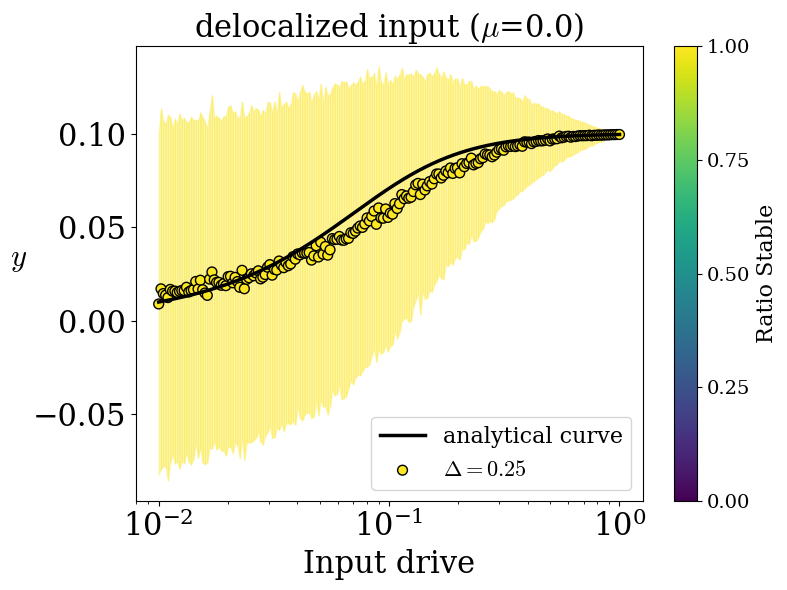

In [11]:
plt.figure(figsize=(8, 6))

# Use plasma colormap and normalize ratio_stable between 0 and 1
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=1)

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [0.25]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

# plot the norm curve
plot = plt.plot(input_range, analytical_mean, label=f"analytical curve", color='black', linewidth=2.5)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx]

    # Calculate the mean and standard deviation along the 3rd dimension
    y_val_mean = torch.nanmean(y_val, dim=2)
    y_val_std = utils.nanstd(y_val, dim=2)

    # Calculate the percentage of stable points for each input drive
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=2) / num_trials

    # Convert tensors to numpy arrays (if on GPU, first move them to CPU)
    x = np.array(input_range)
    y_mean = y_val_mean[0, :].cpu().numpy()
    y_std = y_val_std[0, :].cpu().numpy()
    r_stable = ratio_stable[0, :].cpu().numpy()

    # Scatter plot: each point’s color is determined by its corresponding ratio_stable value.
    # Removed edgecolor to prevent overlapping borders from darkening the color.
    # sc = plt.scatter(x, y_mean, c=r_stable, cmap=cmap, norm=norm, s=50,
                    #  label=f"$\\Delta = {delta_val}$", edgecolors='k')

    # For the envelope, loop over consecutive pairs of points to fill between the mean ± std
    for j in range(len(x) - 1):
        seg_x = x[j:j+2]
        seg_y_lower = y_mean[j:j+2] - y_std[j:j+2]
        seg_y_upper = y_mean[j:j+2] + y_std[j:j+2]
        avg_ratio = np.mean(r_stable[j:j+2])
        seg_color = cmap(norm(avg_ratio))
        plt.fill_between(seg_x, seg_y_lower, seg_y_upper, color=seg_color, alpha=0.3)

sc = plt.scatter(x, y_mean, c=r_stable, cmap=cmap, norm=norm, s=50,
                     label=f"$\\Delta = {delta_val}$", edgecolors='k')

# Add a colorbar for the scatter plot (showing ratio_stable from 0 to 1)
cbar = plt.colorbar(sc, ticks=np.linspace(0, 1, 5))
cbar.set_label("Ratio Stable", fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$y$", fontsize=22, rotation=0, labelpad=10)
plt.title(f"{input_type} input ($\\mu$={mu})", fontsize=22)
plt.xscale('log')
plt.legend(fontsize=16, loc='lower right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()

# folder_loc = f'../figures/mu_{mu}/fig2'
# os.makedirs(folder_loc, exist_ok=True)
# file_name = f'{input_type}_{delta_val}'
# file_save_path = os.path.join(folder_loc, file_name)

# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


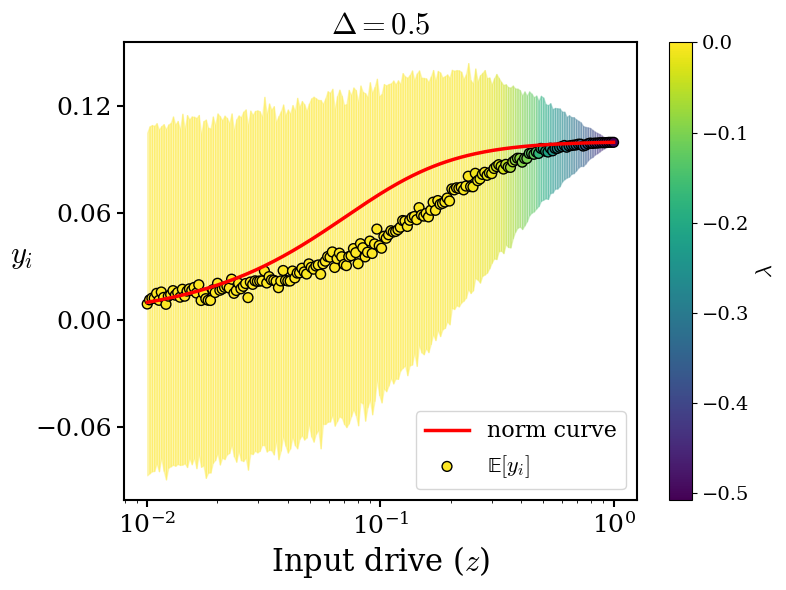

In [77]:
# we plot the curve with dimless colormap
plt.figure(figsize=(8, 6))

# Use plasma colormap and normalize ratio_stable between 0 and 1
cmap = plt.cm.viridis

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [0.5]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

# plot the norm curve
plot = plt.plot(input_range, analytical_mean, label=f"norm curve", color='red', linewidth=2.5)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    eigvals = eigvals_dict[delta_val]
    max_real_each_trial = torch.max(eigvals.real, dim=3)[0] 
    max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2) * 0.002
    vmin = np.nanmin(max_real_max)
    vmax = 0.0
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    y_val = actual_fp_y[:, :, :, idx]

    # Calculate the mean and standard deviation along the 3rd dimension
    y_val_mean = torch.nanmean(y_val, dim=2)
    y_val_std = utils.nanstd(y_val, dim=2)

    # Convert tensors to numpy arrays (if on GPU, first move them to CPU)
    x = np.array(input_range)
    y_mean = y_val_mean[0, :].cpu().numpy()
    y_std = y_val_std[0, :].cpu().numpy()
    max_real_max = max_real_max[0, :]

    # Scatter plot: each point’s color is determined by its corresponding eigenvalues.
    # Removed edgecolor to prevent overlapping borders from darkening the color.
    # sc = plt.scatter(x, y_mean, c=max_real_avg_np, cmap=cmap, norm=norm, s=50,
    #                  label=f"$\\Delta = {delta_val}$", edgecolors='k')

    # For the envelope, loop over consecutive pairs of points to fill between the mean ± std
    for j in range(len(x) - 1):
        seg_x = x[j:j+2]
        seg_y_lower = y_mean[j:j+2] - y_std[j:j+2]
        seg_y_upper = y_mean[j:j+2] + y_std[j:j+2]
        avg_ratio = np.mean(max_real_max[j:j+2])
        seg_color = cmap(norm(avg_ratio))
        plt.fill_between(seg_x, seg_y_lower, seg_y_upper, color=seg_color, alpha=0.3)

sc = plt.scatter(x, y_mean, c=max_real_max, cmap=cmap, norm=norm, s=50,
                     label=r"$\mathrm{\mathbb{E}}[y_i]$", edgecolors='k')

# Add a colorbar for the scatter plot (showing ratio_stable from 0 to 1)
cbar = plt.colorbar(sc)
cbar.set_label("$\lambda$", fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('Input drive ($z$)', fontsize=22)
plt.ylabel(r"$y_i$", fontsize=22, rotation=0, labelpad=10)
plt.title(f"$\\Delta = {delta_val}$", fontsize=22)
plt.xscale('log')
plt.legend(fontsize=16, loc='lower right')

ax = plt.gca()
# request at most 5 major ticks on the y-axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune=None))
ax.tick_params(axis='y')

ax.tick_params(
    axis='both',
    which='major',
    labelsize=18,
    width=1.5,    # tick thickness
    length=5.0    # tick length
)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()

folder_loc = f'../figures/mu_{mu}/fig2'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'{input_type}_{delta_val}_eigval'
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()

Intersection x-value: 0.19626503632568112


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


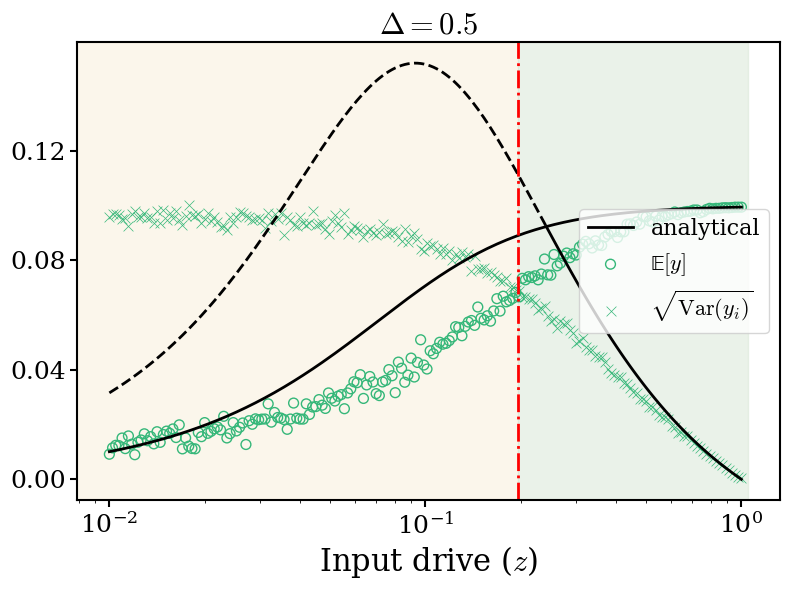

In [76]:
fig, ax = plt.subplots(figsize=(8,6))

ax = plt.gca()

stability_criterion_percent = 0.99

# Plot the norm_sol_idx curve (assumed to be a numpy array)
ax.plot(input_range, analytical_mean, label="analytical", color='black', linewidth=2.0)

# delta_keys = [1.0, 1.5, 2.0, 2.5]
delta_keys = [0.02, 0.1, 0.5, 0.6]
# delta_keys = list(actual_fp_y_dict.keys())


colors_to_use = ['#FF6961', plt.cm.viridis(1 / 3), plt.cm.viridis(2 / 3), '#FFA500',  '#FFA500'] 
min_delta = min(delta_keys)
max_delta = max(delta_keys)

idx_wanted = 2

for i, delta_val in enumerate(delta_keys):
    if not i==idx_wanted:
        continue

    actual_fp_y = actual_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx]

    y_val_mean = torch.nanmean(y_val, dim=2)
    y_val_std = utils.nanstd(y_val, dim=2)

    # Calculate the percentage of stable points for each input drive
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=2) / num_trials
    mask = (ratio_stable[0, :] > stability_criterion_percent).cpu().numpy()


    # plot the mean points
    ax.scatter(np.array(input_range)[mask], y_val_mean[0, :][mask], facecolors='none', s=50, edgecolors=colors_to_use[i], label=r"$\mathrm{\mathbb{E}}[y]$", linewidths=1.0)

    # fit and plot a line
    x_vals = np.array(input_range)[mask].astype(np.float64)
    y_vals = np.array(y_val_mean[0, :][mask]).astype(np.float64)
    coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
    poly_func = np.poly1d(coeffs)
    x_fit_mean = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 200)
    y_fit_mean = poly_func(np.log10(x_fit_mean))
    # plt.plot(x_fit_mean, y_fit_mean, color='red', linewidth=2)


    # Plot the scatter of y_val_std points.
    ax.scatter(
        input_range[mask],
        y_val_std[0, :][mask],
        label=r"$\sqrt{\mathrm{Var}(y_i)}$",
        color=colors_to_use[i],
        linewidth=0.5,
        s=50,
        marker='x'
    )

    # fit and plot a line
    x_vals = np.array(input_range)[mask].astype(np.float64)
    y_vals = np.array(y_val_std[0, :][mask]).astype(np.float64)
    coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
    poly_func = np.poly1d(coeffs)
    x_fit_std = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 200)
    y_fit_std = poly_func(np.log10(x_fit_std))
    # plt.plot(x_fit_std, y_fit_std, color='red', linewidth=2)

    # find and print the point of intersection:
    # Calculate the difference between the two fitted curves.
    diff = y_fit_mean - y_fit_std

    # Find indices where the difference changes sign.
    sign_change_idxs = np.where(np.diff(np.sign(diff)))[0]

    if sign_change_idxs.size > 0:
        # Take the first crossing.
        idx1 = sign_change_idxs[0]
        # Define the two x values and the corresponding differences.
        x0, x1 = x_fit_mean[idx1], x_fit_mean[idx1 + 1]
        d0, d1 = diff[idx1], diff[idx1 + 1]
        
        # Linear interpolation to estimate the intersection.
        t = -d0 / (d1 - d0)
        x_intersect = x0 + t * (x1 - x0)
        
        print("Intersection x-value:", x_intersect)
    else:
        print("No intersection found between the curves.")



    #### Calculate the analytical curve using the given formula.
    analytical_sd = delta_val * input_range * G / math.sqrt(2 * N) 

    # Determine where analytical_sd is greater than norm_sol_idx.
    diff = analytical_sd - norm_sol_idx
    condition = diff > 0  # True when analytical_sd > norm_sol_idx

    # Break the analytical curve into segments based on the condition.
    segments = []
    seg_x = [input_range[0]]
    seg_y = [analytical_sd[0]]
    current_cond = condition[0]

    for j in range(1, len(input_range)):
        new_cond = condition[j]
        if new_cond == current_cond:
            # Continue the segment if the condition hasn't changed.
            seg_x.append(input_range[j])
            seg_y.append(analytical_sd[j])
        else:
            # Condition changes between input_range[j-1] and input_range[j]:
            # Find the intersection point via linear interpolation.
            x0, x1 = input_range[j - 1], input_range[j]
            y0_a, y1_a = analytical_sd[j - 1], analytical_sd[j]
            y0_n, y1_n = norm_sol_idx[j - 1], norm_sol_idx[j]

            # Solve for t in [0,1] such that:
            # y0_a + t*(y1_a - y0_a) = y0_n + t*(y1_n - y0_n)
            t = (y0_n - y0_a) / ((y1_a - y0_a) - (y1_n - y0_n))
            x_int = x0 + t * (x1 - x0)
            y_int = y0_a + t * (y1_a - y0_a)

            # End the current segment at the intersection point.
            seg_x.append(x_int)
            seg_y.append(y_int)
            segments.append((seg_x, seg_y, current_cond))

            # Start a new segment starting at the intersection.
            seg_x = [x_int, input_range[j]]
            seg_y = [y_int, analytical_sd[j]]
            current_cond = new_cond

    # Append the last segment.
    segments.append((seg_x, seg_y, current_cond))

    # Plot each segment with the appropriate linestyle:
    # dashed if analytical_sd > norm_sol_idx, solid otherwise.
    for seg in segments:
        seg_x_data, seg_y_data, cond_flag = seg
        ls = '--' if cond_flag else '-'
        ax.plot(seg_x_data, seg_y_data, color="black", linewidth=2.0, linestyle=ls)
        # if idx_wanted == 0:
        #     ax.plot(seg_x_data, seg_y_data, color="#E65050", linewidth=3.0, linestyle=ls)
        # else:
        #     ax.plot(seg_x_data, seg_y_data, color=colors_to_use[i], linewidth=3.0, linestyle=ls)


if x_intersect > 0:
    ax.axvline(x_intersect, color='r', linestyle='-.', linewidth=2)
    ax.axvspan(-np.inf, x_intersect,
            color='#f8efd8',  
            alpha=0.5,
            zorder=0)
    ax.axvspan(x_intersect, ax.get_xlim()[1],
            color='#d6e6d4',   
            alpha=0.5,
            zorder=0)
## we plot a vertical dashed line to mark slowing down


ax.set_xlabel('Input drive ($z$)', fontsize=22)
# ax.set_ylabel(r"Standard deviation (y)", fontsize=22, labelpad=10)
ax.set_title(f"$\\Delta = {delta_keys[idx_wanted]}$", fontsize=22)
ax.set_xscale('log')
ax.legend(fontsize=16, loc='right')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

# request at most 5 major ticks on the y-axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune=None))
ax.tick_params(axis='y')

ax.tick_params(
    axis='both',
    which='major',
    labelsize=18,
    width=1.5,    # tick thickness
    length=5.0    # tick length
)


for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    
# plt.ylim([0, 0.1])
plt.tight_layout()

folder_loc = f'../figures/mu_{mu}/fig3'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'{input_type}_{delta_keys[idx_wanted]}'
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()